# COMP8831 Machine Learning - Final Project Ver.2
## Brain Tumour Classification Using MRI Images
Submitted By: Akiko Ikeda (1553038)

_*Since my laptop does not have GPU and not capable of working on the project, this assignment is worked on Kaggle notebook with GPU P100. If you find any problem running this file, please try using the same environment._

In [2]:
# DL Libraries
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization  # AveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
import random
from sklearn.metrics import classification_report

# Set the random seed for reproducibility
SEED = 777
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# To handle "GPU MaxPool gradient ops do not yet have a deterministic XLA implementation." error
tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [8]:
# # Check the path
# print(os.listdir('/kaggle/input/brain-tumor-mri-dataset'))

['Training', 'Testing']


In [3]:
# Load training and testing dataset from kaggle
# For this assignment, I get a pre-approval from the lecturer to work on the smaller size images considering the processing time.
# Therefore, all the images are re-sized to 128 x 128.

train_full = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/brain-tumor-mri-dataset/Training',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    seed = SEED
)

test_full = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/brain-tumor-mri-dataset/Testing',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    seed = SEED
)

# Extract class names and create a mapping dictionary from integers to class names
class_names = train_full.class_names 
label_to_text = {i: name for i, name in enumerate(class_names)}
print("Label to text mapping:", label_to_text)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Label to text mapping: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [4]:
# Prepare lists to store images and labels
X_train = []
y_train = []
X_test = []
y_test = []
X_valid = []
y_valid = []

# Load images and labels from the training dataset
for images, labels in train_full:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

# Convert lists to numpy arrays for easier handling
X_train = np.array(X_train)
y_train = np.array(y_train)

# Load images and labels from the testing dataset
for images, labels in test_full:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Convert lists to numpy arrays for easier handling
X_test = np.array(X_test)
y_test = np.array(y_test)

# Preprocess the data and split into training, validation (about 10% of training set), and test sets
X_valid, X_train = X_train[:500].astype('float32') / 255, X_train[500:].astype('float32') / 255
y_valid, y_train = y_train[:500], y_train[500:]
X_test = X_test.astype('float32') / 255

# Check the shapes to confirm
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5212, 128, 128, 3)
y_train shape: (5212,)
x_valid shape: (500, 128, 128, 3)
y_valid shape: (500,)
x_test shape: (1311, 128, 128, 3)
y_test shape: (1311,)


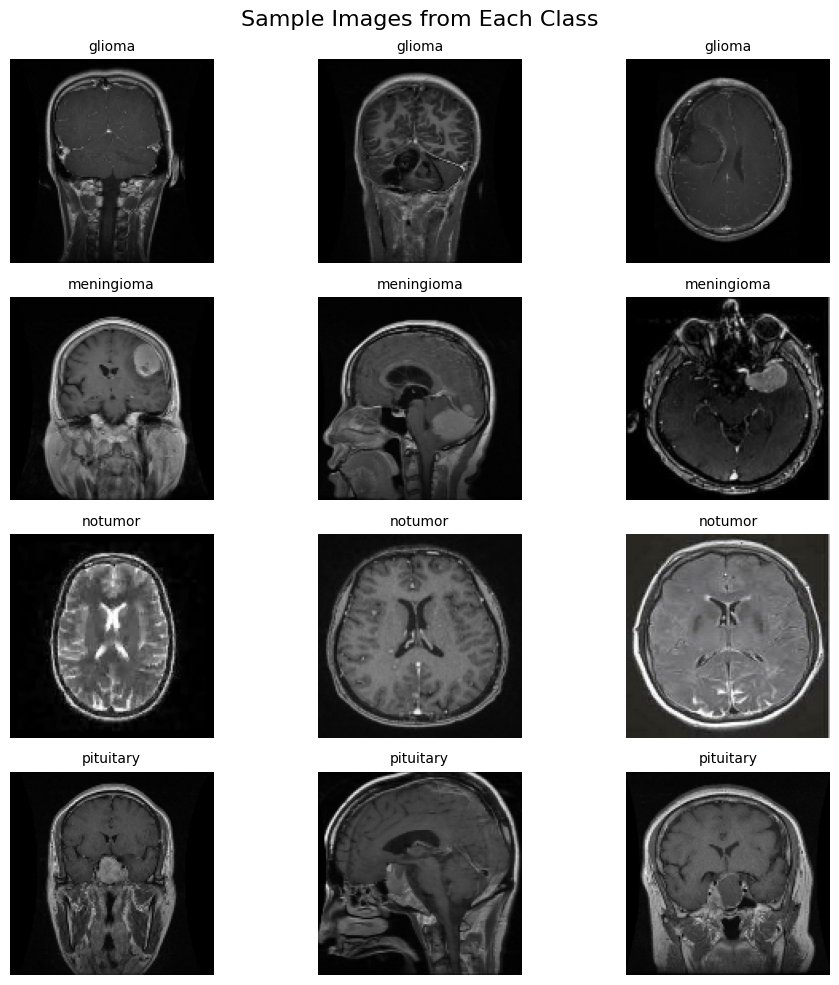

In [5]:
# Display images from each class
# I selected the index to show easy-to-see images, no other meanings

import matplotlib.pyplot as plt

num_classes = len(class_names)
image_index = 7

# Create a figure to display the images
fig, axes = plt.subplots(num_classes, 3, figsize=(10, 10))
fig.suptitle('Sample Images from Each Class', fontsize=16)

# Loop through each class
for i, class_name in enumerate(class_names):
    # Get the indices of images for the current class
    class_indices = np.where(y_train == i)[0]
    selected_indices = class_indices[image_index:image_index+3]

    # Display the selected images
    for j, idx in enumerate(selected_indices):
        ax = axes[i, j]
        ax.imshow(X_train[idx])
        ax.axis('off')
        # Set class name as title for each image
        ax.set_title(class_name, fontsize=10)  

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [36]:
# # Visualising the original dataset
# from collections import Counter

# def plot_class_distribution_pie(dataset, title):
#     class_names = dataset.class_names
#     labels = []
    
#     # Collect the labels from the dataset
#     for _, label_batch in dataset:
#         labels.extend(label_batch.numpy())
        
#     # Count occurrences of each class
#     counts = Counter(labels)
    
#     # Prepare data for plotting
#     classes = list(counts.keys())
#     counts = list(counts.values())

#     # Create a custom function to format the text on the pie chart
#     def func(pct, allvalues):
#         absolute = int(np.round(pct / 100. * sum(allvalues)))  # Calculate the absolute number
#         return f'{absolute} ({pct:.1f}%)'  # Format to display counts and percentage

#     # Create the pie chart
#     plt.figure(figsize=(8, 8))
#     wedges, texts, autotexts = plt.pie(counts, labels=class_names, autopct=lambda pct: func(pct, counts), startangle=140)

#     # # Customize the appearance of the text
#     # for text in autotexts:
#     #     text.set_color('white')  # Set color for percentage text
#     #     text.set_fontsize(10)    # Set font size for percentage text
    
#     plt.title(title)
#     plt.axis('equal')
#     plt.show()
    
#     # # Create the pie chart
#     # plt.figure(figsize=(8, 8))
#     # plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140)
#     # plt.title(title)
#     # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#     # plt.show()


# # Plot for training dataset
# plot_class_distribution_pie(train_full, title='Training Set Class Distribution (Pie Chart)\n')

# # Plot for testing dataset
# plot_class_distribution_pie(test_full, title='Testing Set Class Distribution (Pie Chart)\n')


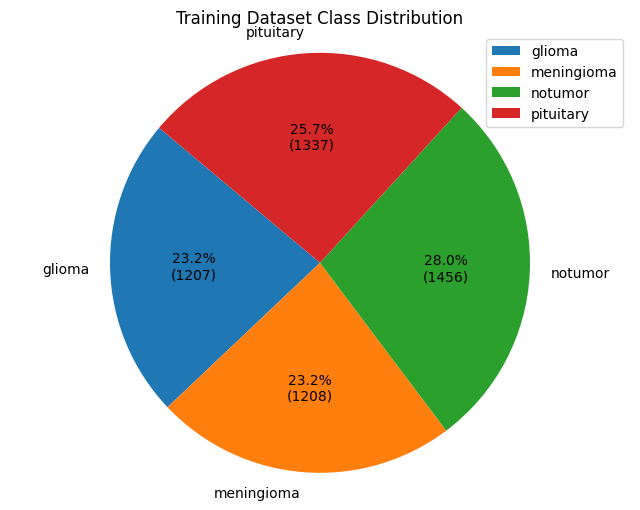

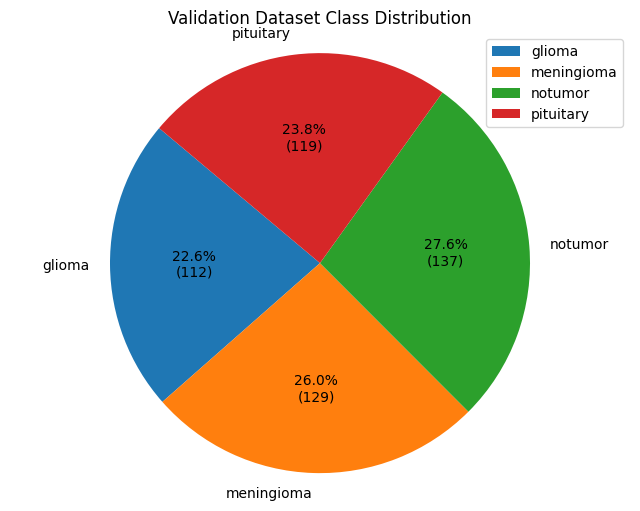

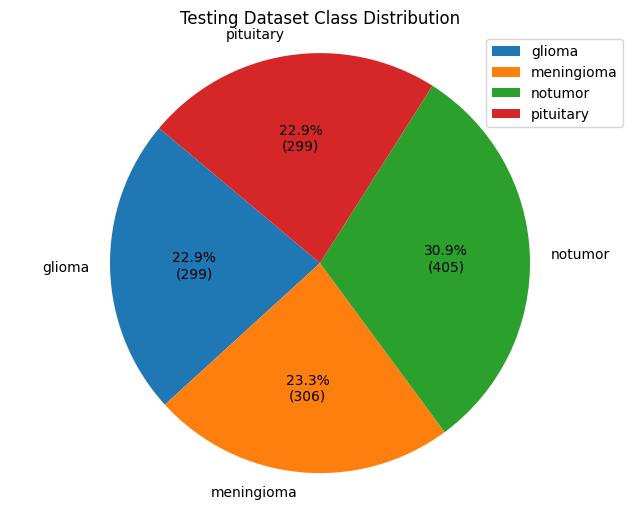

In [68]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, class_names, title):
    # Count occurrences of each class
    class_counts = np.bincount(y)

    # Create a pie chart
    plt.figure(figsize=(8, 6))

    # Define a function to format the labels to show percentage and count
    def func(pct, allvalues):
        absolute = int(pct / 100. * sum(allvalues))
        return f'{pct:.1f}%\n({absolute})'

    # Create the pie chart with class names as labels
    wedges, texts, autotexts = plt.pie(class_counts, 
                                        labels=class_names,
                                        autopct=lambda pct: func(pct, class_counts),
                                        startangle=140)
    # wedges, texts, autotexts = plt.pie(class_counts, 
    #                                     labels=class_names,
    #                                     autopct=lambda pct: func(pct, class_counts),
    #                                     startangle=140)

    # plt.setp(autotexts, size=10, weight="bold")
    # plt.setp(texts, size=10)  # Style for class names
    plt.title(title)
    plt.legend()
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
    plt.show()

# Plot class distribution for training dataset
plot_class_distribution(y_train, class_names, title='Training Dataset Class Distribution')

# Plot class distribution for validation dataset
plot_class_distribution(y_valid, class_names, title='Validation Dataset Class Distribution')

# Plot class distribution for testing dataset
plot_class_distribution(y_test, class_names, title='Testing Dataset Class Distribution')


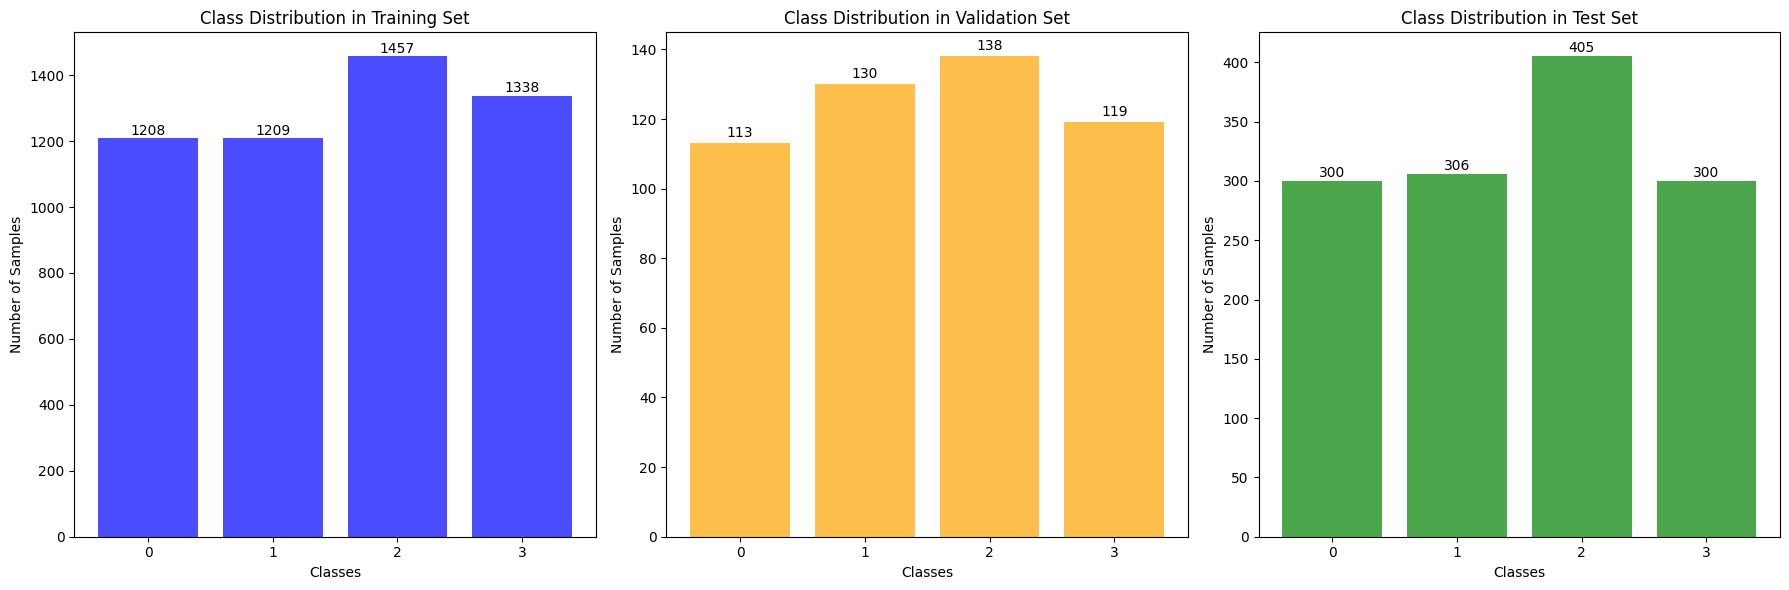

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Function to count samples for each class in the dataset
def count_classes(y):
    class_counts = np.bincount(y, minlength=4)  # Assuming you have 4 classes (0, 1, 2, 3)
    return class_counts

# Assuming your labels are in the following variables
# Replace these with your actual data
# y_train, y_valid, y_test are already defined

# Count samples for each class in training, validation, and test datasets
train_class_counts = count_classes(y_train)
val_class_counts = count_classes(y_valid)
test_class_counts = count_classes(y_test)

# Labels for the classes
class_labels = np.arange(4)  # Adjust based on the number of classes

# Create subplots for the class distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Function to annotate bars with counts
def annotate_bars(ax, counts):
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', va='bottom')

# Plot class distribution for training set
axs[0].bar(class_labels, train_class_counts, color='blue', alpha=0.7)
axs[0].set_title('Class Distribution in Training Set')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Number of Samples')
axs[0].set_xticks(class_labels)
annotate_bars(axs[0], train_class_counts)  # Annotate counts on bars

# Plot class distribution for validation set
axs[1].bar(class_labels, val_class_counts, color='orange', alpha=0.7)
axs[1].set_title('Class Distribution in Validation Set')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Number of Samples')
axs[1].set_xticks(class_labels)
annotate_bars(axs[1], val_class_counts)  # Annotate counts on bars

# Plot class distribution for test set
axs[2].bar(class_labels, test_class_counts, color='green', alpha=0.7)
axs[2].set_title('Class Distribution in Test Set')
axs[2].set_xlabel('Classes')
axs[2].set_ylabel('Number of Samples')
axs[2].set_xticks(class_labels)
annotate_bars(axs[2], test_class_counts)  # Annotate counts on bars

# Show the plots
plt.tight_layout()
plt.show()


In [69]:
# import matplotlib.pyplot as plt

# def visualize_dataset(X, y, class_names, title, images_per_class=4):
#     num_classes = len(class_names)

#     # Create a figure to display the images
#     fig, axes = plt.subplots(num_classes, images_per_class, figsize=(12, 12))
#     fig.suptitle(title, fontsize=16)

#     # Iterate through each class
#     for i, class_name in enumerate(class_names):
#         # Get the indices of images for the current class
#         class_indices = np.where(y == i)[0]

#         # Select the first `images_per_class` indices
#         selected_indices = class_indices[:images_per_class]

#         # Display the selected images
#         for j, idx in enumerate(selected_indices):
#             ax = axes[i, j]
#             ax.imshow(X[idx])
#             ax.axis('off')  # Hide axis ticks
#             ax.set_title(class_name, fontsize=10)  # Set class name as title for each image

#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
#     plt.show()

# # Visualize training dataset
# visualize_dataset(X_train, y_train, class_names, title='Training Dataset Samples')

# # Visualize validation dataset
# visualize_dataset(X_valid, y_valid, class_names, title='Validation Dataset Samples')

# # Visualize testing dataset
# visualize_dataset(X_test, y_test, class_names, title='Testing Dataset Samples')


In [4]:
# # Split the data into training, validation, and test sets and preprocess it
# from tensorflow.keras import layers
# # X_valid, X_train = X_train_full[:5000].astype('float32') / 255, X_train_full[5000:].astype('float32') / 255
# # y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# # X_test = X_test.astype('float32') / 255

# # Split the training dataset into training and validation sets
# val_size = int(0.1 * len(train_full))  # Use 10% for validation
# train_size = len(train_full) - val_size

# train_dataset = train_full.take(train_size)
# val_dataset = train_full.skip(train_size)

# # Normalize the datasets
# normalization_layer = layers.Rescaling(1.0 / 255)

# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_full.map(lambda x, y: (normalization_layer(x), y))

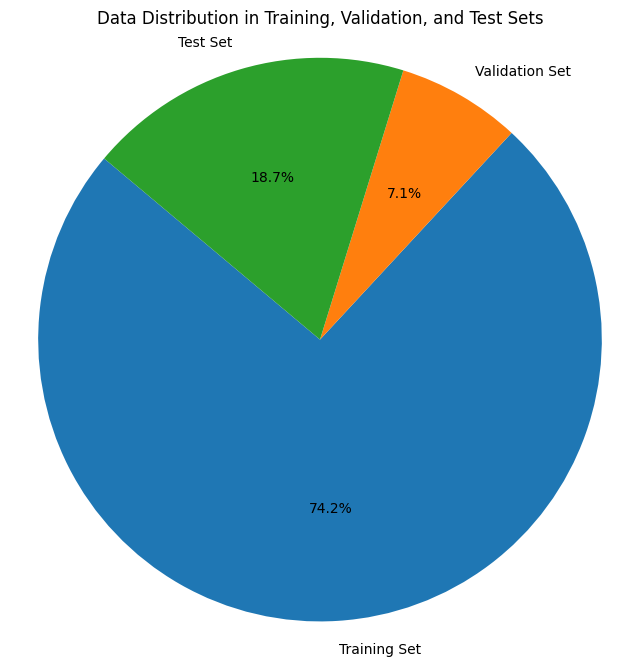

In [75]:
# import matplotlib.pyplot as plt

# # Assume train_dataset, val_dataset, and test_dataset are defined as in your code
# # Get the counts of samples in each dataset
# train_count = sum(1 for _ in train_dataset)
# val_count = sum(1 for _ in val_dataset)
# test_count = sum(1 for _ in test_dataset)

# # Prepare data for the pie chart
# sizes = [train_count, val_count, test_count]
# labels = ['Training Set', 'Validation Set', 'Test Set']

# # Create a pie chart
# plt.figure(figsize=(8, 8))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
# plt.title('Data Distribution in Training, Validation, and Test Sets')
# plt.show()


import matplotlib.pyplot as plt

# Assume you have the following lists defined:
# X_train, X_valid, X_test

# Get the counts of samples in each dataset
train_count = len(X_train)
val_count = len(X_valid)
test_count = len(X_test)

# Prepare data for the pie chart
sizes = [train_count, val_count, test_count]
labels = ['Training Set', 'Validation Set', 'Test Set']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.title('Data Distribution in Training, Validation, and Test Sets')
plt.show()


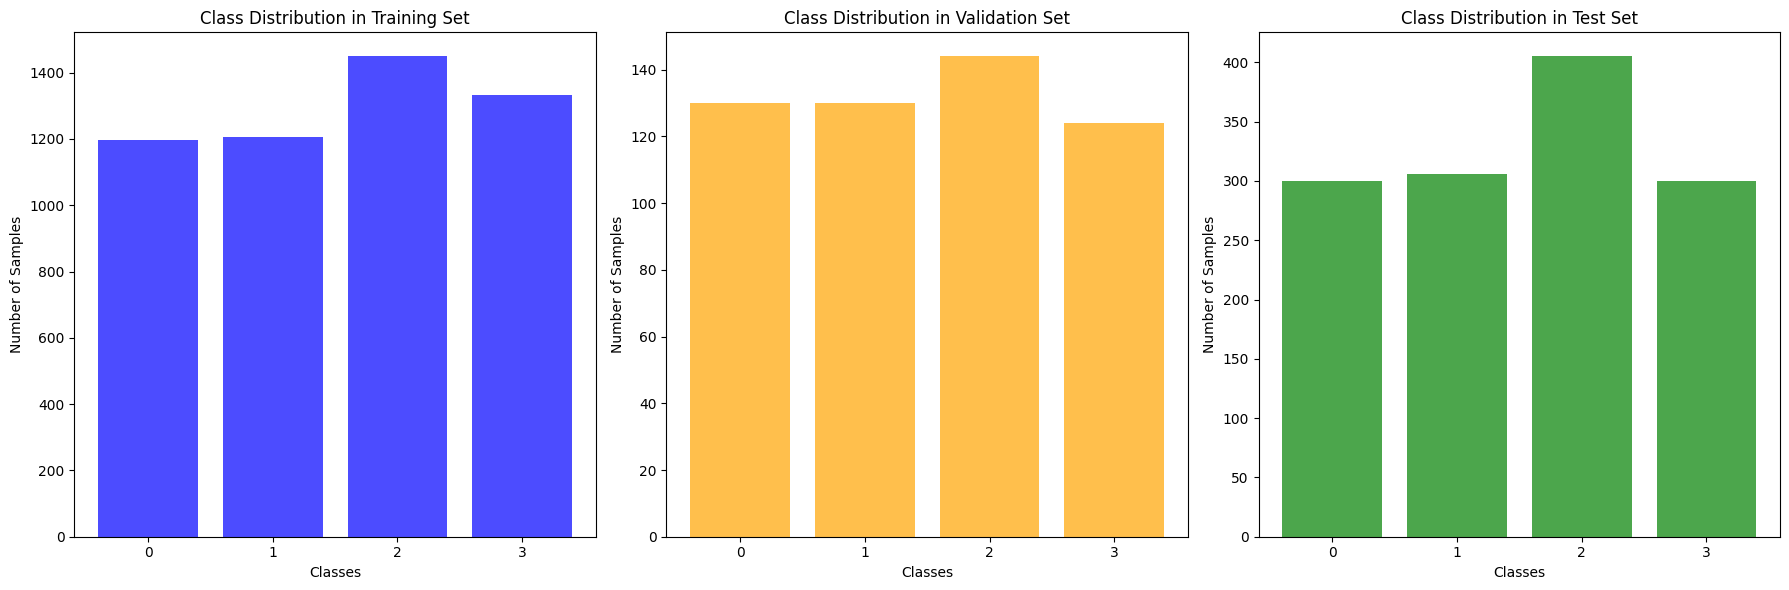

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to count samples for each class in the dataset
# def count_classes(dataset):
#     class_counts = [0] * 4  # Assuming you have 4 classes, indexed from 0 to 3
#     for _, labels in dataset:
#         for label in labels.numpy():  # Convert labels to numpy array if necessary
#             class_counts[label] += 1
#     return class_counts

# # Count samples for each class in training, validation, and test datasets
# train_class_counts = count_classes(train_dataset)
# val_class_counts = count_classes(val_dataset)
# test_class_counts = count_classes(test_dataset)

# # Labels for the classes
# class_labels = [0, 1, 2, 3]  # Adjust these labels based on your class names

# # Create subplots for the class distributions
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot class distribution for training set
# axs[0].bar(class_labels, train_class_counts, color='blue', alpha=0.7)
# axs[0].set_title('Class Distribution in Training Set')
# axs[0].set_xlabel('Classes')
# axs[0].set_ylabel('Number of Samples')
# axs[0].set_xticks(class_labels)

# # Plot class distribution for validation set
# axs[1].bar(class_labels, val_class_counts, color='orange', alpha=0.7)
# axs[1].set_title('Class Distribution in Validation Set')
# axs[1].set_xlabel('Classes')
# axs[1].set_ylabel('Number of Samples')
# axs[1].set_xticks(class_labels)

# # Plot class distribution for test set
# axs[2].bar(class_labels, test_class_counts, color='green', alpha=0.7)
# axs[2].set_title('Class Distribution in Test Set')
# axs[2].set_xlabel('Classes')
# axs[2].set_ylabel('Number of Samples')
# axs[2].set_xticks(class_labels)

# # Show the plots
# plt.tight_layout()
# plt.show()


In [76]:
# Data Augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

## Model 1: NN

In [77]:
# Build the first model (NN)

nn_model = Sequential()
nn_model.add(keras.layers.InputLayer(shape=[128, 128, 3]))
nn_model.add(Flatten())
nn_model.add(BatchNormalization())

nn_model.add(Dense(512, activation="selu", kernel_initializer="lecun_normal"))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))

nn_model.add(Dense(256, activation="selu", kernel_initializer="lecun_normal"))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))

nn_model.add(Dense(128, activation="selu", kernel_initializer="lecun_normal"))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))

nn_model.add(Dense(4, activation="softmax"))

# Compile the model
nn_model.compile(loss="sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"])

# Set Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# nn_history = nn_model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])
nn_history = nn_model.fit(datagen.flow(X_train, y_train, batch_size=64, shuffle=False, seed=SEED), epochs=50, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

# # Train the model
# history_cnn_augmented = model_cnn_augmented.fit(datagen.flow(X_train_cnn, y_train_cnn, batch_size=32, shuffle=False, seed=77), epochs=15, validation_data=(X_valid_cnn, y_valid_cnn))

# Evaluate the model
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/82 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4682 - loss: 1.7215

KeyboardInterrupt: 

## Model 2: CNN

In [ ]:
# Build the second model (CNN)

# Set the random seed for reproducibility
SEED = 777
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

# To handle "GPU MaxPool gradient ops do not yet have a deterministic XLA implementation." error
tf.config.run_functions_eagerly(True)

# Build a model
cnn_model = Sequential()

cnn_model.add(keras.layers.InputLayer(shape=[128, 128, 3]))
cnn_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3, seed=SEED))

cnn_model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3, seed=SEED))

cnn_model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3, seed=SEED))

cnn_model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3, seed=SEED))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation="selu", kernel_initializer="lecun_normal"))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5, seed=SEED))

cnn_model.add(Dense(64, activation="selu", kernel_initializer="lecun_normal"))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5, seed=SEED))

cnn_model.add(Dense(4, activation="softmax"))

# Compile the model
cnn_model.compile(loss="sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"])

# Set Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
cnn_history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=64, shuffle=False, seed=SEED), epochs=50, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

# Evaluate the model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test accuracy for CNN model: {cnn_test_accuracy:.4f}')

In [10]:
# # Build the second model (CNN)

# # Set the random seed for reproducibility
# SEED = 777
# os.environ['PYTHONHASHSEED'] = str(SEED)
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)
# tf.keras.utils.set_random_seed(SEED)

# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# # To handle "GPU MaxPool gradient ops do not yet have a deterministic XLA implementation." error
# tf.config.run_functions_eagerly(True)

# cnn_model = Sequential()

# cnn_model.add(keras.layers.InputLayer(shape=[128, 128, 3]))
# cnn_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(2,2))
# cnn_model.add(Dropout(0.3, seed=SEED))

# cnn_model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(2,2))
# cnn_model.add(Dropout(0.3, seed=SEED))

# cnn_model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(2,2))
# cnn_model.add(Dropout(0.3, seed=SEED))

# cnn_model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(2,2))
# cnn_model.add(Dropout(0.3, seed=SEED))

# cnn_model.add(Flatten())
# cnn_model.add(Dense(128, activation="selu", kernel_initializer="lecun_normal"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.5, seed=SEED))

# cnn_model.add(Dense(64, activation="selu", kernel_initializer="lecun_normal"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.5, seed=SEED))

# cnn_model.add(Dense(4, activation="softmax"))

# # Compile the model
# cnn_model.compile(loss="sparse_categorical_crossentropy",
#     optimizer = keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["accuracy"])

# # Set Early Stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model
# cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])

# # Evaluate the model
# cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_dataset)
# print(f'Test accuracy: {cnn_test_accuracy:.4f}')

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.6471 - loss: 1.0446 - val_accuracy: 0.2519 - val_loss: 10.1471
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 327ms/step - accuracy: 0.7948 - loss: 0.5683 - val_accuracy: 0.2633 - val_loss: 6.4816
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 0.8404 - loss: 0.4577 - val_accuracy: 0.3409 - val_loss: 3.3269
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 0.8818 - loss: 0.3517 - val_accuracy: 0.4167 - val_loss: 2.4772
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.8911 - loss: 0.3053 - val_accuracy: 0.4337 - val_loss: 4.0911
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - accuracy: 0.9116 - loss: 0.2594 - val_accuracy: 0.4545 - val_loss: 2.2198
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - accuracy: 0.9144 - loss: 0.2242 - val_accuracy: 0.7481 - val_loss: 0.7396
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - accuracy: 0.9319 - loss: 0.2011 - val_acc

In [ ]:
# Evaluation
from sklearn.metrics import classification_report

print("NN Model Classification Report")
nn_y_pred = nn_model.predict(X_test)
nn_y_pred = np.argmax(nn_y_pred, axis=1)
print(classification_report(y_test, nn_y_pred))

print("CNN Model Classification Report")
cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred = np.argmax(cnn_y_pred, axis=1)
print(classification_report(y_test, cnn_y_pred))

In [11]:
# # Evaluation
# from sklearn.metrics import classification_report

# # Extract true labels from the test dataset
# y_test = []
# # y_test = test_dataset.labels

# # Convert tensor to numpy and append
# for _, labels in test_dataset:
#     y_test.extend(labels.numpy())  

# y_test = np.array(y_test)

# print("NN Model Classification Report")
# nn_y_pred = nn_model.predict(test_dataset)
# nn_y_pred = np.argmax(nn_y_pred, axis=1)
# print(classification_report(y_test, nn_y_pred))

# print("CNN Model Classification Report")
# cnn_y_pred = cnn_model.predict(test_dataset)
# cnn_y_pred = np.argmax(cnn_y_pred, axis=1)
# print(classification_report(y_test, cnn_y_pred))


NN Model Classification Report
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
              precision    recall  f1-score   support

           0       0.23      0.24      0.24       300
           1       0.28      0.25      0.26       306
           2       0.33      0.34      0.34       405
           3       0.23      0.22      0.22       300

    accuracy                           0.27      1311
   macro avg       0.27      0.26      0.26      1311
weighted avg       0.27      0.27      0.27      1311

CNN Model Classification Report
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

           0       0.25      0.22      0.24       300
           1       0.22      0.23      0.22       306
           2       0.31      0.32      0.31       405
           3       0.22      0.23      0.22       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.2

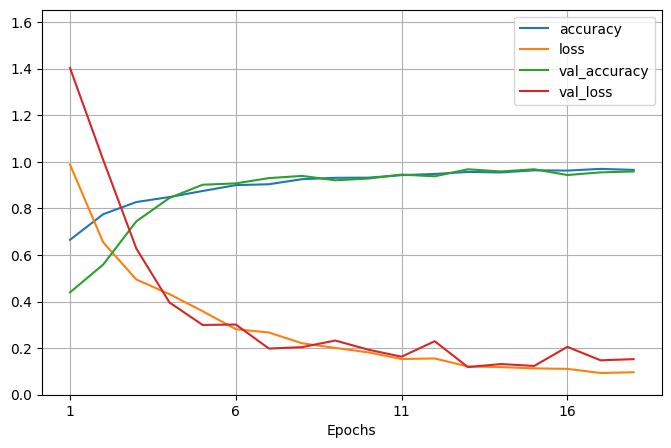

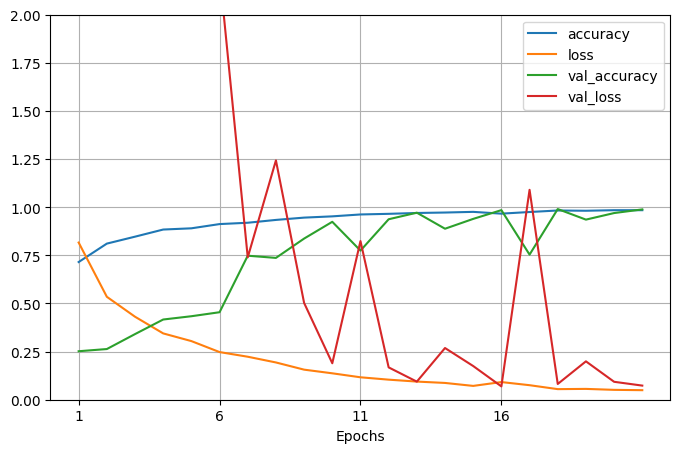

In [30]:
import pandas as pd
history_nn_df = pd.DataFrame(nn_history.history)
history_nn_df.index +=1
history_nn_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(max(nn_history.history['loss']), max(nn_history.history['val_loss'])) + 0.25)
plt.xticks(np.arange(1, 21, 5))
plt.xlabel('Epochs')
plt.show()

history_cnn_df = pd.DataFrame(cnn_history.history)
history_cnn_df.index +=1
history_cnn_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xticks(np.arange(1, 21, 5))
plt.xlabel('Epochs')
plt.show()

In [35]:
# predicted_classes = np.argmax(nn_model.predict(test_dataset), axis = 1)
# confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
# plt.figure(figsize = (16, 16))
# sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
# print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

# # Check the type of y_test
# print(type(y_test))

# # If y_test is a NumPy array, you can also check its dtype
# if isinstance(y_test, np.ndarray):
#     print("Data type of y_test:", y_test.dtype)

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Check the unique classes and their counts
# unique, counts = np.unique(y_test, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# # Plot class distribution
# sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
# plt.title('Class Distribution in y_test')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.show()

# Display some of the predictions vs true labels
# for i in range(20):  # Change the range as needed to see more predictions
#     print(f"True: {y_test[i]}, Predicted: {y_pred[i]}")


True: 3, Predicted: [4.0333958e-05 9.9956685e-01 3.7557306e-04 1.7328468e-05]
True: 0, Predicted: [7.4234090e-09 2.4540943e-06 2.9465076e-05 9.9996805e-01]
True: 2, Predicted: [5.8277999e-07 5.7524102e-07 1.4104144e-06 9.9999738e-01]
True: 2, Predicted: [1.3342751e-06 7.4631830e-06 9.9998868e-01 2.4756303e-06]
True: 3, Predicted: [7.7971854e-06 3.9328157e-04 1.4050147e-05 9.9958485e-01]
True: 2, Predicted: [1.6724128e-06 1.6935272e-05 9.9995577e-01 2.5587136e-05]
True: 3, Predicted: [1.7630927e-06 4.4272248e-05 1.1620199e-05 9.9994242e-01]
True: 0, Predicted: [4.9238897e-06 4.2542475e-03 9.9572432e-01 1.6546572e-05]
True: 3, Predicted: [1.02790146e-07 1.51137119e-05 9.99984503e-01 1.85107666e-07]
True: 3, Predicted: [9.9954540e-01 2.4963729e-04 1.5107272e-04 5.3919164e-05]
True: 1, Predicted: [9.9507844e-01 3.7172160e-03 1.1765363e-03 2.7850487e-05]
True: 3, Predicted: [9.8575902e-01 1.2876495e-02 2.8712716e-04 1.0774079e-03]
True: 3, Predicted: [4.007759e-08 5.919801e-07 9.999993e-01 

In [12]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, cnn_y_pred))

# print(classification_report(y_test, nn_y_pred))

              precision    recall  f1-score   support

           0       0.25      0.22      0.24       300
           1       0.22      0.23      0.22       306
           2       0.31      0.32      0.31       405
           3       0.22      0.23      0.22       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.26      1311

              precision    recall  f1-score   support

           0       0.23      0.24      0.24       300
           1       0.28      0.25      0.26       306
           2       0.33      0.34      0.34       405
           3       0.23      0.22      0.22       300

    accuracy                           0.27      1311
   macro avg       0.27      0.26      0.26      1311
weighted avg       0.27      0.27      0.27      1311



In [18]:
# # Print some predictions and true labels
# for i in range(100):  # Change 10 to however many samples you want to check
#     print(f"True label: {y_test[i]}, Predicted label: {cnn_y_pred[i]}")


True label: 3, Predicted label: 3
True label: 0, Predicted label: 0
True label: 2, Predicted label: 1
True label: 2, Predicted label: 2
True label: 3, Predicted label: 2
True label: 2, Predicted label: 1
True label: 3, Predicted label: 1
True label: 0, Predicted label: 0
True label: 3, Predicted label: 3
True label: 3, Predicted label: 3
True label: 1, Predicted label: 1
True label: 3, Predicted label: 0
True label: 3, Predicted label: 0
True label: 1, Predicted label: 1
True label: 3, Predicted label: 3
True label: 1, Predicted label: 3
True label: 2, Predicted label: 1
True label: 2, Predicted label: 2
True label: 0, Predicted label: 1
True label: 3, Predicted label: 0
True label: 0, Predicted label: 1
True label: 1, Predicted label: 2
True label: 3, Predicted label: 2
True label: 3, Predicted label: 2
True label: 3, Predicted label: 2
True label: 1, Predicted label: 2
True label: 1, Predicted label: 1
True label: 1, Predicted label: 1
True label: 0, Predicted label: 3
True label: 1,

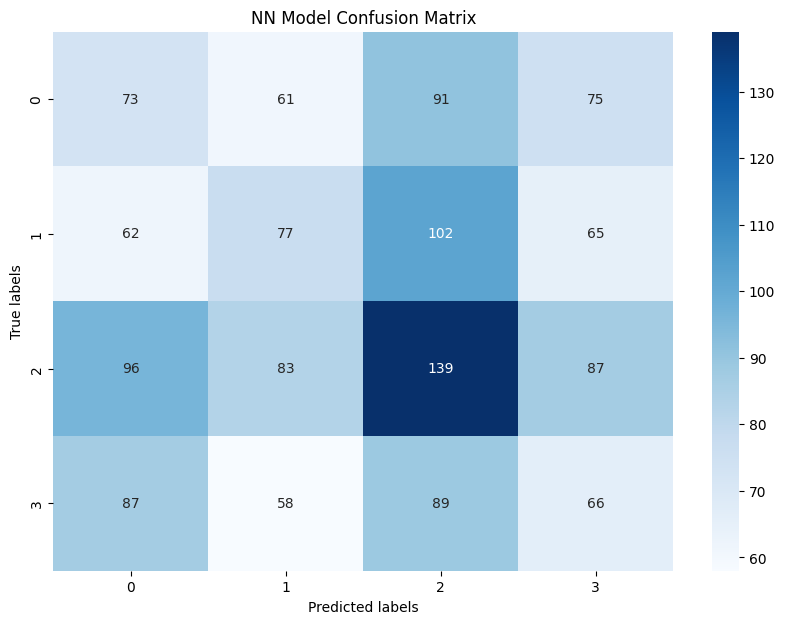

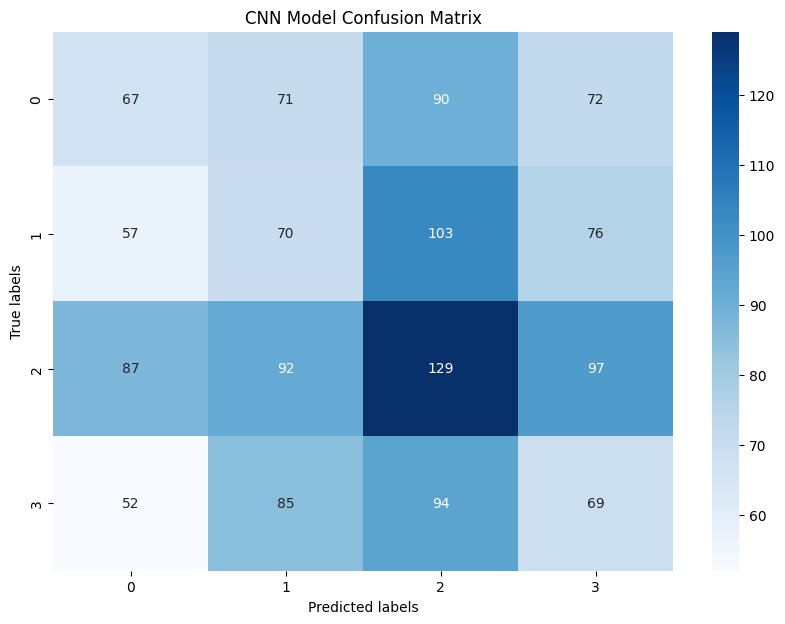

In [14]:
from sklearn.metrics import confusion_matrix

nn_confusion_matrix = confusion_matrix(y_test, nn_y_pred)
cnn_confusion_matrix = confusion_matrix(y_test, cnn_y_pred)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(nn_confusion_matrix, 'NN Model Confusion Matrix')
plot_confusion_matrix(cnn_confusion_matrix, 'CNN Model Confusion Matrix')

In [25]:
# # print(f'Predicted labels shape: {cnn_y_pred.shape}')
# # print(f'True labels shape: {y_test.shape}')

# # print("True labels shape:", y_test.shape)
# # print("NN predicted labels shape:", nn_y_pred.shape)
# # print("CNN predicted labels shape:", cnn_y_pred.shape)


# from sklearn.metrics import classification_report, accuracy_score
# import numpy as np

# # Get predictions from model.predict()
# predictions = nn_model.predict(test_dataset)
# predicted_labels = np.argmax(predictions, axis=1)

# # Ensure labels are in the correct format
# true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
# # true_labels = np.argmax(true_labels, axis=1)

# # Print a classification report to compare
# print("Manual Classification Report:")
# print(classification_report(true_labels, predicted_labels))

# # Calculate manual accuracy
# manual_accuracy = accuracy_score(true_labels, predicted_labels)
# print("Manual accuracy:", manual_accuracy)

# # Compare this with model.evaluate() to check for consistency
# loss, evaluate_accuracy = nn_model.evaluate(test_dataset, true_labels)
# print("Evaluate accuracy:", evaluate_accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Manual Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.28      0.27       300
           1       0.25      0.23      0.24       306
           2       0.31      0.32      0.31       405
           3       0.24      0.23      0.24       300

    accuracy                           0.27      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.27      0.27      0.27      1311

Manual accuracy: 0.26773455377574373


ValueError: When providing `x` as a tf.data.Dataset, `y` should not be passed. Instead, the targets should be included as part of the tf.data.Dataset.

In [16]:
# models summaries
print("NN model summary:")
nn_model.summary()
print("\nCNN model summary:")
cnn_model.summary()

NN model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 49152)          │       196,608 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,393,614 (291.42 MB)

 Trainable params: 25,431,172 (97.01 MB)

 Non-trainable params: 100,096 (391.00 KB)

 Optimizer params: 50,862,346 (194.02 MB)


CNN model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 17,270,990 (65.88 MB)

 Trainable params: 5,756,228 (21.96 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 11,512,458 (43.92 MB)